In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import supervision as sv

In [2]:
# Обученная модель YOLO лежит по данному пути 
# (два файла с весами: веса с лучшей эпохи и веса с последней эпохи) - best и last.
model = YOLO('runs/detect/train/weights/best.pt')
# Переводим модель в режим eval
model.fuse()
# Названия видео
input_video = "test_video_2.mp4"
output_video = "out.mp4"
# Названия классов у модели
class_names = model.names

YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


## Типовой случай - подаем на вход фото или несколько фоток и получаем результаты

0: 640x640 1 license_plate, 152.6ms
1: 640x640 1 license_plate, 152.6ms
Speed: 411.8ms preprocess, 152.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


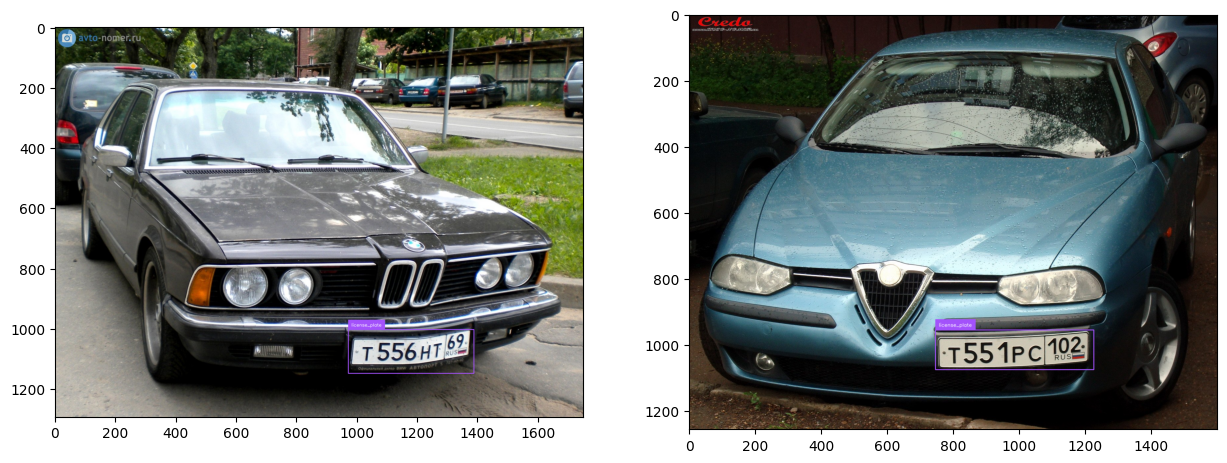

In [15]:
list_of_images = ["cars_images/images/20335.jpg", "cars_images/images/15295.jpg"]
list_of_cv2_instances = [cv2.imread(image) for image in list_of_images]

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Подаем в модель список картинок
results = model.predict(list_of_images)

# Итерация по каждой картинке, обработанной моделью
for index in range(len(results)):
    # Получение детекций
    detections = sv.Detections.from_ultralytics(results[index])

    # Инициализация экземпляров классов для боксов и подписей
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # вывод доп информации (лейбл обнаруженного класса)
    labels = [
    model.model.names[class_id]
    for class_id
    in detections.class_id
    ]

    # Непосредственно, рисуем боксы и подписи
    image_with_bounding_box = bounding_box_annotator.annotate(
        scene=list_of_cv2_instances[index], detections=detections)

    annotated_image = label_annotator.annotate(
        scene=image_with_bounding_box, detections=detections, labels=labels)

    # Чтобы картинка адекватно отображалась - сконвертируем из BGR в RGB
    image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    
    # Добавляем subplot
    ax[index].imshow(image_rgb)

## Запись видео с детекциями

In [ ]:
# Открываем видео средствами OpenCV
video_capture = cv2.VideoCapture(input_video)

# Получаем основные свойства видео
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

In [ ]:
# Определяем кодек и создаем объект VideoWriter 
# для формирования результирующего видео
fourcc = cv2.VideoWriter_fourcc(*'X264')
out_video = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height))

frame_count = 0
while video_capture.isOpened():
    # boolean значение об успешном считывании кадра и сам кадр
    ret, frame = video_capture.read()
    if not ret:
        break
    # Детекции модели
    results = model.predict(frame, conf = 0.5, imgsz = 640)[0]
    boxes_data = results.boxes.xyxy.numpy().astype(int)
    for result in boxes_data:
        # Вытаскиваем метаданные из детекций модели
        x1, y1, x2, y2 = result[:4]
        # Непосредственно, отрисовка Bounding-box-а
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 4)
    # Обрабатываем каждый кадр
    out_video.write(frame)
    frame_count += 1
    print(f'Processed frame {frame_count} / {total_frames}')
# Освобождаем ресурсы
video_capture.release()
out_video.release()
cv2.destroyAllWindows()


## Детекция в Real-Time

In [ ]:
# Открываем видео средствами OpenCV
video_capture = cv2.VideoCapture(input_video)

# Получаем основные свойства видео
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

In [ ]:
while True:
    # boolean значение об успешном считывании кадра и сам кадр
    ret, frame = video_capture.read()
    if not ret:
        break
    # Детекции модели TODO изучить детальнее трекинг кадров 
    # - в текущем инференесе видео дико лагает, а при пропадании bbox-ов - в следующих кадрах им назначаются новые id-шники
    results = model.predict(frame, conf = 0.5, imgsz = 640)[0]

    # Получаем метаданные детекций
    boxes_data = results.boxes.data.cpu().numpy().astype(int)
    # Цикл по найденным автомобильным номерам в каждом кадре
    for box_data in boxes_data:
        # Вытаскиваем метаданные из детекций модели
        x1, y1, x2, y2, cls = box_data[:5]
        # Для вывода класса, к которому принадлежит bounding-box
        class_name = class_names[cls]
        # Непосредственно, отрисовка Bounding-box-а
        cv2.rectangle(frame, 
                        (x1, y1), 
                        (x2, y2), 
                        (0, 0, 255), 
                        4)
        # Выводим доп.текст над Bounding-box-ами
        cv2.putText(
            frame,
            f"{class_name}",
            (x1, y1),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 255)
        )
    # Для того, чтобы видео адекватно отображалось в окошке
    frame = cv2.resize(frame, (0, 0), fx=0.75, fy=0.75)
    # Показываем кадры
    cv2.imshow("frame", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
        
video_capture.release()
cv2.destroyAllWindows()
    